In [115]:
# importing data analysis package
import pandas as pd
import numpy as np
import re
pd.set_option('display.max_columns', None)

# importing visualization package
from plotnine import *

# importing linear regression package
import statsmodels.formula.api as smf

# Load and clean the data

In this part, we want to create two dataframes:
1. **Containing one-year data of 20 big cities in Japan**
    - name in English and Japanese character
        - city
        - 市
    - 2017 move in/out young population devided by age and gender
        - m_15-19, m_20-24, m_25-29
        - f_15-19, f_20-24, f_25-29
        - male_move = m_15-19 + m_20-24 + m_25-29
        - female_move = f_15-19 + f_20-24 + f_25-29
    - 2017 university student number devided by gender
        - male_uni_student
        - female_uni_student
        - student_total
    - 2017 population of the city devided by gender
        - total_pop


2. **Containing six-year data of all cities and counties in Japan**
    - name and catagory of the place
        - place
        - city_county
    - year of the data
        - year
    - move in/out young population devided by age and gender
        - m_15-19, m_20-24, m_25-29
        - f_15-19, f_20-24, f_25-29
    - 2020 population of the city devided by gender
        - total_pop
        - male_pop
        - female_pop

Note: The reason why we include population data is to consider the scale of the city, so that we can normalize the raw number by calculating the percentage.

## Dataframe 1: city_data_2017

In [116]:
move2017 = pd.read_csv("2017_pop_move_net.csv",encoding="SHIFT-JIS")
uni = pd.read_csv("2017_uni_student.csv",encoding="SHIFT-JIS")
population = pd.read_csv("2017_pop_total.csv",encoding="SHIFT-JIS")

### clean the pop_move_net data

In [117]:
city = ["Sapporo", "Sendai","Saitama","Chiba","Tokyo", \
        "Yokohama","Kawasaki","Sagamihara","Nigata","Shizuoka", \
        "Hamamatsu","Nagoya", "Kyoto","Osaka","Sakai",\
        "Kobe","Okayama","Hiroshima", \
        "Kitakyusyu","Fukuoka","kumamoto"]
move2017 = move2017.drop(move2017.columns[[0,2]], axis=1) \
          .drop(move2017.index[[0,1]]) \
          .set_axis(["市","m_15-19","m_20-24","m_25-29","f_15-19","f_20-24","f_25-29"], axis=1)
move2017.insert(loc=0, column = "city", value = city)

In [118]:
# save the 2017_population data and reread it
move2017.to_csv("2017_pop_move_clean.csv",index=False)
population_move = pd.read_csv("2017_pop_move_clean.csv", thousands=',')

### clean the university data

In [5]:
uni = uni.rename(columns={'Unnamed: 0': '市'})

uni.male_uni_student = uni.male_uni_student.apply(str).str.replace(',', '')
uni.female_uni_student = uni.female_uni_student.apply(str).str.replace(',', '')
uni.male_uni_student = uni.male_uni_student.astype(int)
uni.female_uni_student = uni.female_uni_student.astype(int)

uni['student_total'] = uni.male_uni_student + uni.female_uni_student

### merge and clean the final dataframe

In [6]:
df = population_move.merge(uni,on= '市').merge(population,on='市')
df["male_move"] = df["m_15-19"] + df["m_20-24"] +df["m_25-29"]
df["female_move"] = df["f_15-19"] + df["f_20-24"] +df["f_25-29"]
df.to_csv("2017_city_data.csv",index=False)
city_data_2017 = pd.read_csv("2017_city_data.csv")
city_data_2017.head()

,city,市,m_15-19,m_20-24,m_25-29,f_15-19,f_20-24,f_25-29,male_uni_student,female_uni_student,student_total,population,male_move,female_move
0,Sapporo,札幌市,518,197,172,838,1239,196,26780,17610,44390,1952356,887,2273
1,Sendai,仙台市,638,314,110,620,679,-28,21796,17548,39344,1082159,1062,1271
2,Saitama,さいたま市,436,911,585,270,1074,715,9556,4856,14412,1263979,1932,2059
3,Chiba,千葉市,265,489,-38,265,345,-169,12145,10343,22488,971882,716,441
4,Tokyo,特別区部,4434,23602,10216,5367,27772,9750,245162,217508,462670,9272740,38252,42889


## Dataframe 2: six_year_data

In [7]:
df2021 = pd.read_csv("pop_move2021.csv",encoding="SHIFT-JIS")
df2020 = pd.read_csv("pop_move2020.csv",encoding="SHIFT-JIS")
df2019 = pd.read_csv("pop_move2019.csv",encoding="SHIFT-JIS")
df2018 = pd.read_csv("pop_move2018.csv",encoding="SHIFT-JIS")
df2017 = pd.read_csv("pop_move2017.csv",encoding="SHIFT-JIS")
df2016 = pd.read_csv("pop_move2016.csv",encoding="SHIFT-JIS")

### clean the population movement data

In [8]:
def clean(df):
    df_new = df.drop(df.columns[[0,3]], axis=1) \
               .set_axis(["year","place","total_15_19","total_20_24", "total_25_29",\
                              "m_15_19","m_20_24", "m_25_29",\
                              "f_15_19","f_20_24", "f_25_29"], axis=1) \
               .drop(df.index[[0,1]], axis=0)
    df_new["city_county"]= df_new.place.str.extract("(市部|市|郡部|振興局|郡|特別区部|支庁)")
    df_new.city_county = df_new.city_county.str.replace("市部","city_group").str.replace("市","city").str.replace("郡部","county_group") \
                    .str.replace("市部","city_group").str.replace("市","city").str.replace("特別区部","Tokyo")\
                    .str.replace("振興局","county").str.replace("郡","county").str.replace("支庁","county")
    df_new = df_new[(df_new.city_county != "city_group")&(df_new.city_county != "county_group")]
    df_new.year = df_new.year.str.replace("年","")
    return df_new

In [9]:
def clean2(df):
    df_new = df.drop(df.columns[[0,2]], axis=1) \
               .set_axis(["place","total_15_19","total_20_24", "total_25_29",\
                              "m_15_19","m_20_24", "m_25_29",\
                              "f_15_19","f_20_24", "f_25_29"], axis=1) \
               .drop(df.index[[0,1]], axis=0)
    df_new["city_county"]= df_new.place.str.extract("(市部|市|郡部|振興局|郡|特別区部|支庁)")
    df_new.city_county = df_new.city_county.str.replace("市部","city_group").str.replace("市","city").str.replace("郡部","county_group") \
                    .str.replace("市部","city_group").str.replace("市","city").str.replace("特別区部","Tokyo")\
                    .str.replace("振興局","county").str.replace("郡","county").str.replace("支庁","county")
    df_new = df_new[(df_new.city_county != "city_group")&(df_new.city_county != "county_group")]
    return df_new

In [10]:
new_2021 = clean(df2021)
new_2020 = clean(df2020)
new_2019 = clean2(df2019)
new_2019.insert(0, 'year', 2019)
new_2018 = clean2(df2018)
new_2018.insert(0, 'year', 2018)
new_2017 = clean2(df2017)
new_2017.insert(0, 'year', 2017)
new_2016 = clean2(df2016)
new_2016.insert(0, 'year', 2016)

In [13]:
pop_move_2016_2021 = pd.concat([new_2016, new_2017, new_2018,new_2019,new_2020,new_2021], axis=0)
pop_move_2016_2021 = pop_move_2016_2021.replace(',','', regex=True)
colums_to_convert = [x for x in pop_move_2016_2021.columns if re.search('\d', x)]
pop_move_2016_2021[colums_to_convert] = pop_move_2016_2021[colums_to_convert].astype(float)
pop_move_2016_2021.place = pop_move_2016_2021.place.str.replace("東京都特別区部","特別区部")
pop_move_2016_2021.to_csv("output_2016_2021.csv", index=False)

In [14]:
df = pd.read_csv("output_2016_2021.csv").replace(',','', regex=True)
df2 = df.drop_duplicates(['year', 'place', 'city_county'])

### load and merge the 2020 population data

In [15]:
pop20 = pd.read_csv('each_pop_2020.csv', thousands=',')
six_year_data = df2.merge(pop20, how='left', on='place')

In [17]:
six_year_data.head()

,year_x,place,total_15_19,total_20_24,total_25_29,m_15_19,m_20_24,m_25_29,f_15_19,f_20_24,f_25_29,city_county,year_y,total_pop,male_pop,female_pop
0,2016,札幌市,1485.0,1643.0,205.0,588.0,463.0,75.0,897.0,1180.0,130.0,city,2020.0,1973395.0,918682.0,1054713.0
1,2016,函館市,-325.0,-322.0,-169.0,-213.0,-153.0,-59.0,-112.0,-169.0,-110.0,city,2020.0,251084.0,113965.0,137119.0
2,2016,小樽市,-16.0,-333.0,-192.0,-21.0,-189.0,-58.0,5.0,-144.0,-134.0,city,2020.0,111299.0,50136.0,61163.0
3,2016,旭川市,-242.0,-283.0,-286.0,-155.0,-99.0,-97.0,-87.0,-184.0,-189.0,city,2020.0,329306.0,152108.0,177198.0
4,2016,室蘭市,96.0,-208.0,-159.0,108.0,-138.0,-95.0,-12.0,-70.0,-64.0,city,2020.0,82383.0,40390.0,41993.0


# Exploratory data analysis

## population overall in Japan

In [18]:
# Biggest places in 2021
six_year_data.query("year_x==2020").sort_values(by='total_pop', ascending=False).head()

,year_x,place,total_15_19,total_20_24,total_25_29,m_15_19,m_20_24,m_25_29,f_15_19,f_20_24,f_25_29,city_county,year_y,total_pop,male_pop,female_pop
4795,2020,特別区部,6763.0,52208.0,15403.0,3068.0,24780.0,8635.0,3695.0,27428.0,6768.0,Tokyo,2020.0,9733276.0,4774402.0,4958874.0
4828,2020,横浜市,1662.0,6435.0,1743.0,777.0,3160.0,997.0,885.0,3275.0,746.0,city,2020.0,3777491.0,1867305.0,1910186.0
5137,2020,大阪市,1537.0,13423.0,5358.0,580.0,6147.0,2935.0,957.0,7276.0,2423.0,city,2020.0,2752412.0,1326875.0,1425537.0
5035,2020,名古屋市,810.0,6509.0,1681.0,395.0,3289.0,804.0,415.0,3220.0,877.0,city,2020.0,2332176.0,1146669.0,1185507.0
4446,2020,札幌市,1672.0,2046.0,660.0,755.0,917.0,342.0,917.0,1129.0,318.0,city,2020.0,1973395.0,918682.0,1054713.0


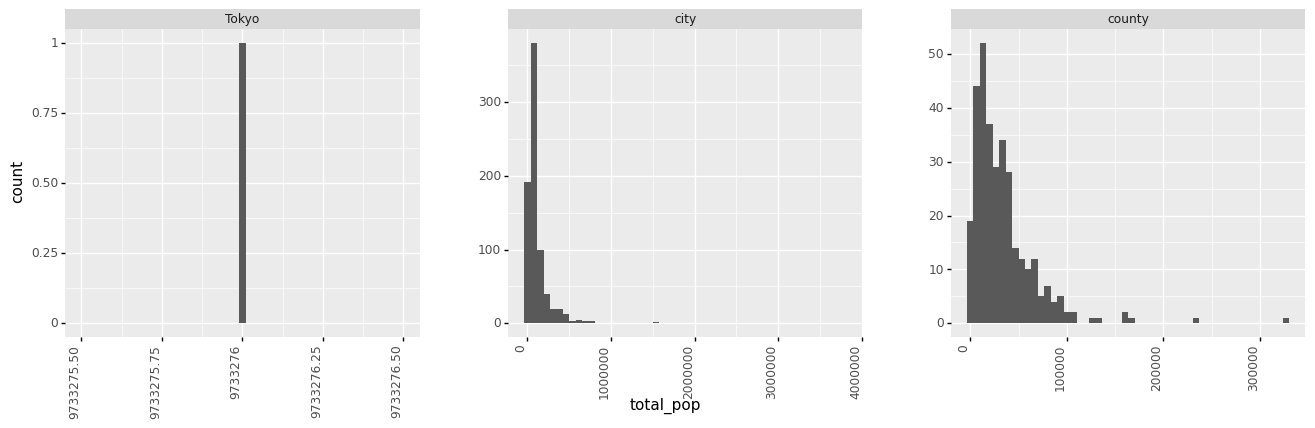

<ggplot: (299879741)>

In [19]:
# Distribution of population in cities and counties
(
    ggplot(six_year_data.query("year_x==2020"), aes(x="total_pop")) 
    + geom_histogram(bins=50) 
    + facet_wrap('city_county', scales='free')
    + theme(
        axis_text_x = element_text(angle = 90, hjust = 1),
        figure_size=(16,4),
        subplots_adjust={'wspace': 0.25}
    )
)

In [20]:
# The gender difference: In general, 51% of Japan population is female
gender_pct = six_year_data.copy()
gender_pct['pct_male'] = gender_pct['male_pop'] / gender_pct['total_pop'] * 100
gender_pct['pct_female'] = gender_pct['female_pop'] / gender_pct['total_pop'] * 100

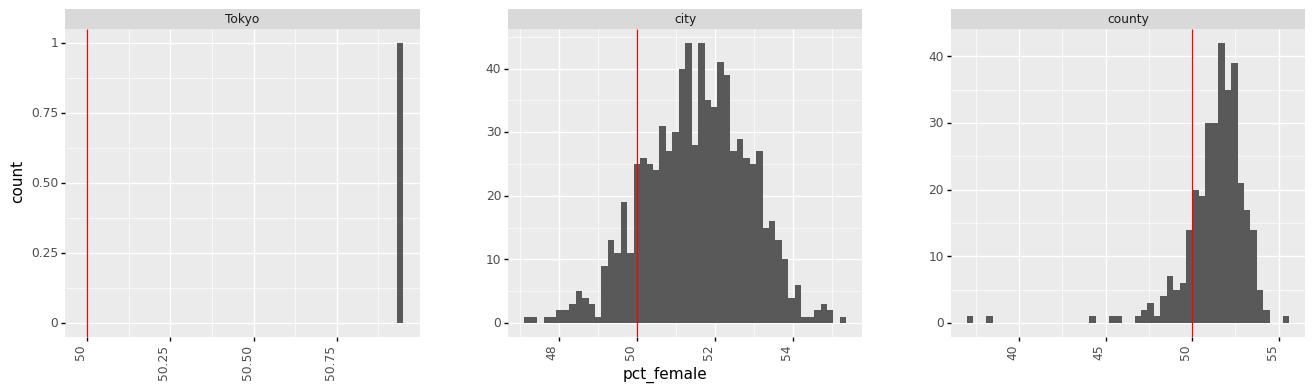

<ggplot: (299066543)>

In [21]:
(
    ggplot(gender_pct.query("year_x==2020"), aes(x="pct_female")) 
    + geom_histogram(bins=50) 
    + geom_vline(aes(xintercept=50), color='red')
    + facet_wrap('city_county', scales='free')
    + theme(
        axis_text_x = element_text(angle = 90, hjust = 1),
        figure_size=(16,4),
        subplots_adjust={'wspace': 0.25}
    )
)

In [22]:
print("Most female places")
display(
    gender_pct.sort_values(by='pct_female', ascending=False).query('year_x==2020')[
    ['year_x', 'place', 'pct_male', 'pct_female', 'total_pop', 'city_county']].head(10)
)

print("Most male places")
display(
    gender_pct.sort_values(by='pct_female', ascending=True).query('year_x==2020')[
    ['year_x', 'place', 'pct_male', 'pct_female', 'total_pop', 'city_county']].head(10)
)


Most female places


,year_x,place,pct_male,pct_female,total_pop,city_county
5180,2020,芦屋市,44.726475,55.273525,93922.0,city
5326,2020,阿武郡,44.746318,55.253682,3055.0,county
4448,2020,小樽市,45.046227,54.953773,111299.0,city
5010,2020,熱海市,45.129794,54.870206,34208.0,city
4467,2020,三笠市,45.161692,54.838308,8040.0,city
4500,2020,五所川原市,45.224156,54.775844,51415.0,city
4463,2020,赤平市,45.246443,54.753557,9698.0,city
4447,2020,函館市,45.389192,54.610808,251084.0,city
5486,2020,別府市,45.436651,54.563349,115321.0,city
5395,2020,田川市,45.572798,54.427202,46203.0,city


Most male places


,year_x,place,pct_male,pct_female,total_pop,city_county
4625,2020,双葉郡,62.970153,37.029847,16484.0,county
4827,2020,小笠原支庁,61.625128,38.374872,2929.0,county
4825,2020,三宅支庁,55.855162,44.144838,2596.0,county
5441,2020,東松浦郡,54.679979,45.320021,5609.0,county
5556,2020,宮古郡,54.347826,45.652174,1058.0,county
5352,2020,香川郡,53.045440,46.954560,3103.0,county
5059,2020,知立市,52.812600,47.187400,72193.0,city
5536,2020,鹿児島郡,52.663755,47.336245,1145.0,county
5557,2020,八重山郡,52.616590,47.383410,5618.0,county
4612,2020,南相馬市,52.563342,47.436658,59005.0,city


## The movement percentage

In [86]:
df_pct = six_year_data.copy()
df_pct = df_pct.assign(
    total_youth = lambda x: x.total_15_19 + x.total_20_24 + x.total_25_29,
    total_male_youth =  lambda x: x.m_15_19 + x.m_20_24 + x.m_25_29,
    total_female_youth =  lambda x: x.f_15_19 + x.f_20_24 + x.f_25_29
)

In [87]:
migration_columns = ['total_15_19', 'total_20_24', 'total_25_29', 
                     'm_15_19', 'm_20_24', 'm_25_29', 
                     'f_15_19', 'f_20_24', 'f_25_29',
                     'total_youth', 'total_male_youth', 'total_female_youth']

for column in migration_columns:
    df_pct[column] = df_pct[column] / df_pct['total_pop'] * 100

df_pct['city_county'] = df_pct.city_county.replace({'Tokyo': 'city'})

/Users/angeline_jcq/.pyenv/versions/3.9.7/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 5 rows containing missing values.


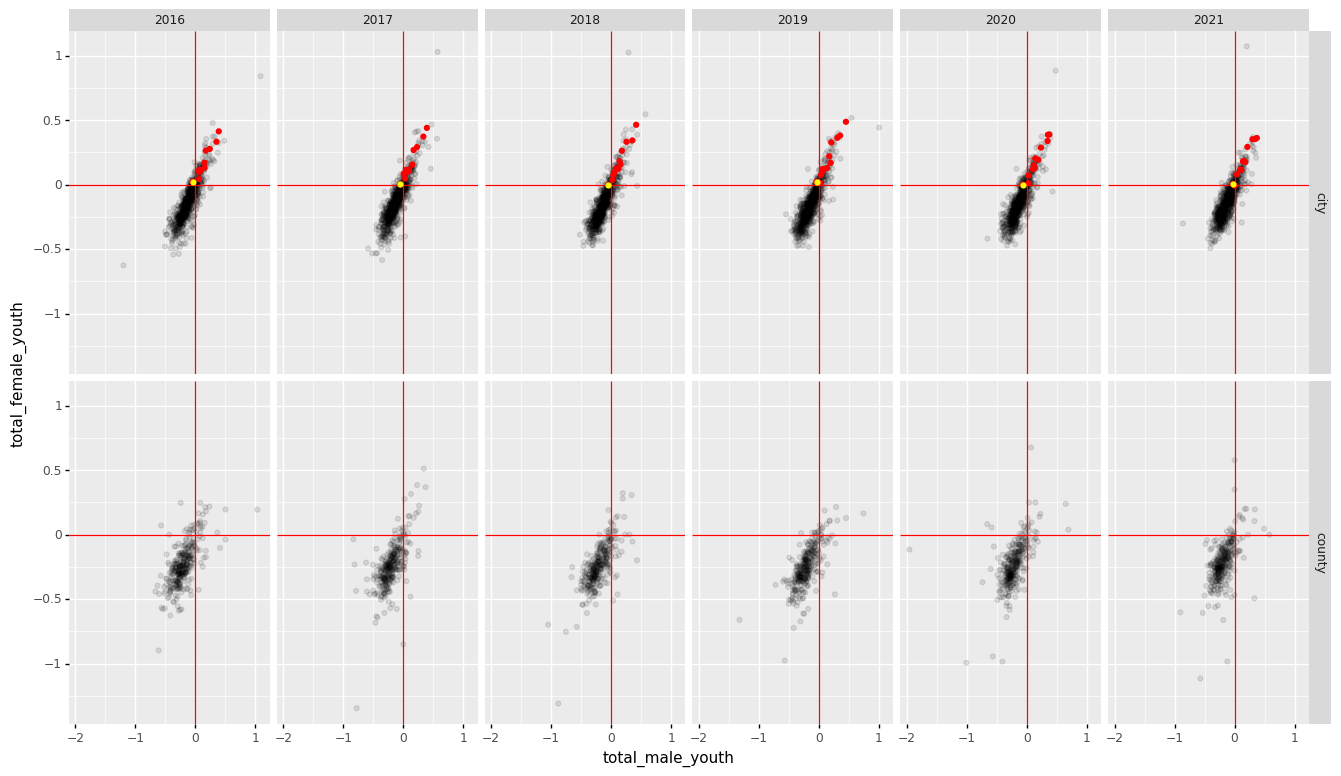

<ggplot: (301677123)>

In [93]:
(
    ggplot(df_pct, aes(x='total_male_youth', y='total_female_youth')) + 
        geom_point(alpha=.1) +
        geom_hline(aes(yintercept=0), color='red') + 
        geom_vline(aes(xintercept=0), color='red') + 
        geom_point(data=df_pct.query('total_pop > 1000000'), color='red') + 
        geom_point(data=df_pct.query("place=='神戸市'"), color='yellow') + 
        facet_grid('city_county~year_x') + 
        theme(figure_size=(16,9))
)

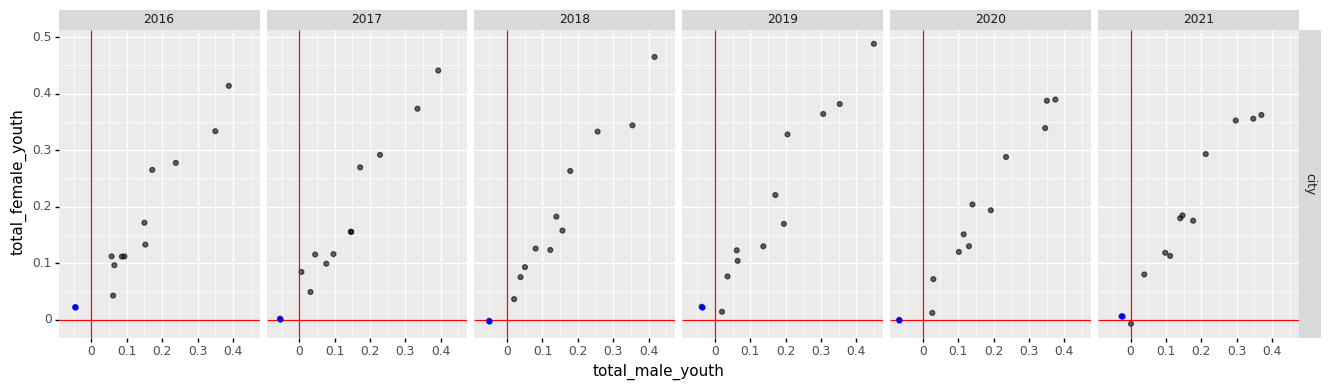

<ggplot: (301816402)>

In [119]:
(
    ggplot(df_pct.query('total_pop > 1000000'), aes(x='total_male_youth', y='total_female_youth')) + 
        geom_point(alpha=.6) +
        geom_hline(aes(yintercept=0), color='red') + 
        geom_vline(aes(xintercept=0), color='red') + 
        geom_point(data=df_pct.query("place=='神戸市'"), color='blue') + 
        facet_grid('city_county~year_x') + 
        theme(figure_size=(16,4))
)

## The relationship between university student and young pop movement

In this part, we add several percentage columns in the 2017 city data:
- male_migration_15_24: the total number of male migration population in two age groups (15-19 and 20-24)
- male_migration_15_24_pct: the percentage of 15-24 male migration in all 15-24 migration population
- male_migration_15_29_pct: the male young migration percentage

- female_migration_15_24: the total number of female migration population in two age groups (15-19 and 20-24)
- female_migration_15_24_pct: the percentage of 15-24 female migration in all 15-24 migration population
- female_migration_15_29_pct: the female young migration percentage


In [120]:
city_pct = city_data_2017.copy()
city_pct.columns = city_pct.columns.str.replace('-','_')

city_pct['pct_15_19'] = (city_pct.m_15_19 + city_pct.f_15_19) / city_pct.population
city_pct['pct_20_24'] = (city_pct.m_20_24 + city_pct.f_20_24) / city_pct.population
city_pct['pct_25_29'] = (city_pct.m_25_29 + city_pct.f_25_29) / city_pct.population
city_pct['pct_15_19_male'] = city_pct.m_15_19 / city_pct.population
city_pct['pct_15_19_female'] = city_pct.f_15_19 / city_pct.population
city_pct['pct_20_24_male'] = city_pct.m_20_24 / city_pct.population
city_pct['pct_20_24_female'] = city_pct.f_20_24 / city_pct.population
city_pct['pct_25_29_male'] = city_pct.m_25_29 / city_pct.population
city_pct['pct_25_29_female'] = city_pct.f_25_29 / city_pct.population

city_pct['male_migration_15_24'] = city_pct['m_15_19'] + city_pct['m_20_24']
city_pct['male_migration_15_24_pct'] = (city_pct['m_15_19'] + city_pct['m_20_24']) \
                            / (city_pct['f_15_19'] + city_pct['f_20_24'] + city_pct['m_15_19'] + city_pct['m_20_24'])
city_pct['male_migration_15_29_pct'] = city_pct.male_move \
                            / (city_pct.male_move + city_pct.female_move)

city_pct['female_migration_15_24'] = city_pct['f_15_19'] + city_pct['f_20_24']
city_pct['female_migration_15_24_pct'] = (city_pct['f_15_19'] + city_pct['f_20_24']) \
                            / (city_pct['f_15_19'] + city_pct['f_20_24'] + city_pct['m_15_19'] + city_pct['m_20_24'])
city_pct['female_migration_15_29_pct'] = city_pct.female_move \
                            / (city_pct.male_move + city_pct.female_move)

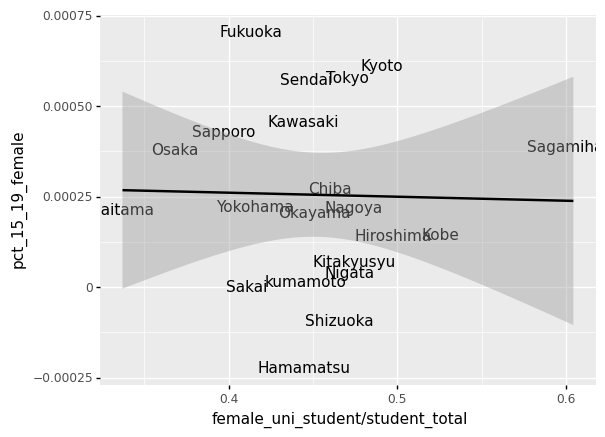

<ggplot: (300290774)>

In [121]:
(
    ggplot(city_pct, aes(y='pct_15_19_female', x= 'female_uni_student/student_total'))
    + geom_text(aes(label='city'))
    + stat_smooth(method='lm')
)

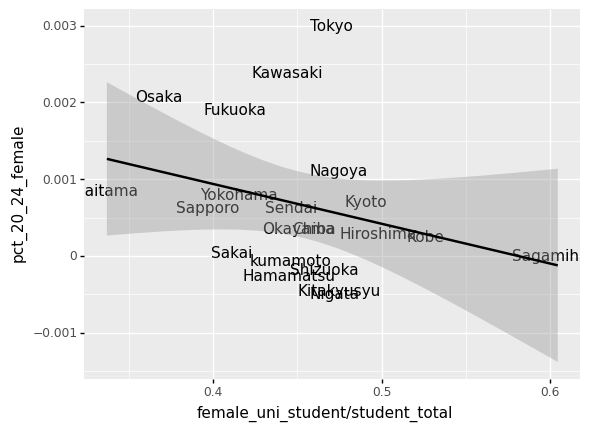

<ggplot: (304367559)>

In [122]:
(
    ggplot(city_pct, aes(y='pct_20_24_female', x= 'female_uni_student/student_total'))
    + geom_text(aes(label='city'))
    + stat_smooth(method='lm')
)

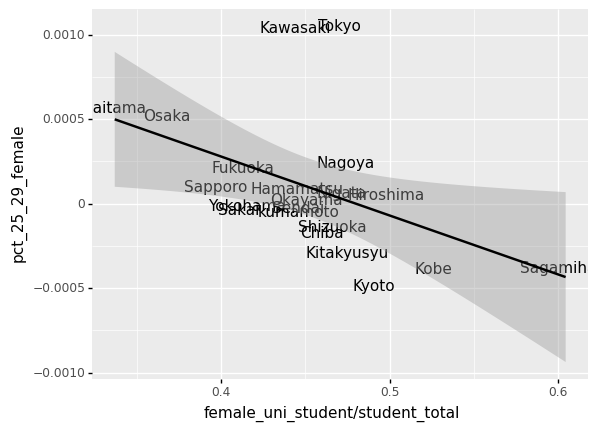

<ggplot: (304396770)>

In [123]:
(
    ggplot(city_pct, aes(y='pct_25_29_female', x= 'female_uni_student/student_total'))
    + geom_text(aes(label='city'))
    + stat_smooth(method='lm')
)

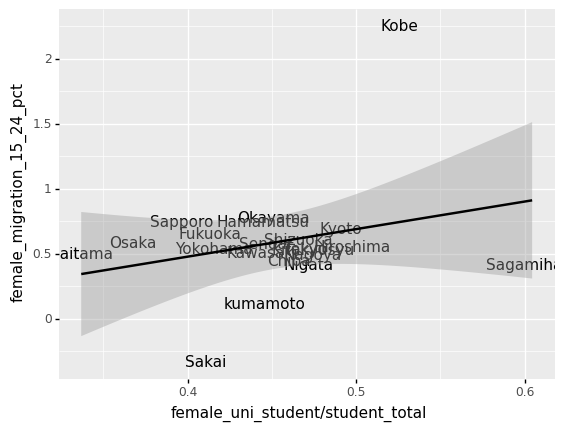

<ggplot: (299383390)>

In [27]:
(
    ggplot(city_pct, aes(y='female_migration_15_24_pct', x= 'female_uni_student/student_total'))
    + geom_text(aes(label='city'))
    + stat_smooth(method='lm')
)

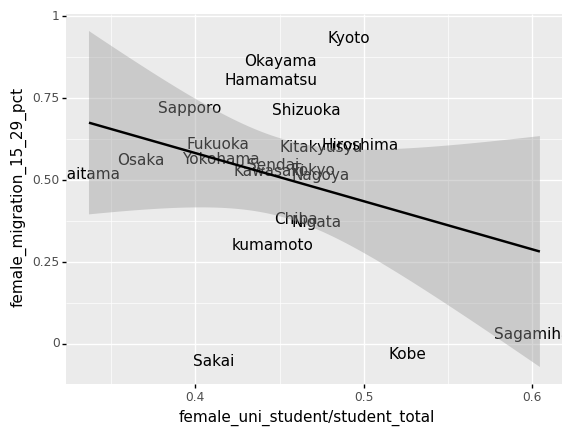

<ggplot: (298967682)>

In [99]:
(
    ggplot(city_pct, aes(y='female_migration_15_29_pct', x= 'female_uni_student/student_total'))
    + geom_text(aes(label='city'))
    + stat_smooth(method='lm')
)

In [105]:
city_data_2017

,city,市,m_15-19,m_20-24,m_25-29,f_15-19,f_20-24,f_25-29,male_uni_student,female_uni_student,student_total,population,male_move,female_move
0,Sapporo,札幌市,518,197,172,838,1239,196,26780,17610,44390,1952356,887,2273
1,Sendai,仙台市,638,314,110,620,679,-28,21796,17548,39344,1082159,1062,1271
2,Saitama,さいたま市,436,911,585,270,1074,715,9556,4856,14412,1263979,1932,2059
3,Chiba,千葉市,265,489,-38,265,345,-169,12145,10343,22488,971882,716,441
4,Tokyo,特別区部,4434,23602,10216,5367,27772,9750,245162,217508,462670,9272740,38252,42889
5,Yokohama,横浜市,949,2245,-308,825,2952,-41,43924,31208,75132,3724844,2886,3736
6,Kawasaki,川崎市,847,3288,1007,676,3527,1536,15592,12458,28050,1475213,5142,5739
7,Sagamihara,相模原市,237,158,-15,280,4,-273,6621,10117,16738,720780,380,11
8,Nigata,新潟市,-67,-439,-16,32,-393,53,10407,9293,19700,810157,-522,-308
9,Shizuoka,静岡市,-49,-76,7,-65,-129,-97,7697,6713,14410,704989,-118,-291


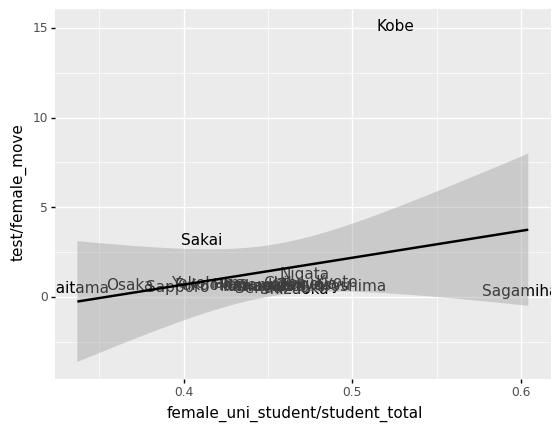

<ggplot: (305094705)>

In [111]:
(
    ggplot(city_data_2017.rename(columns={'f_20-24':'test'}), aes(y='test/female_move', x= 'female_uni_student/student_total'))
    + geom_text(aes(label='city'))
    + stat_smooth(method='lm')
)

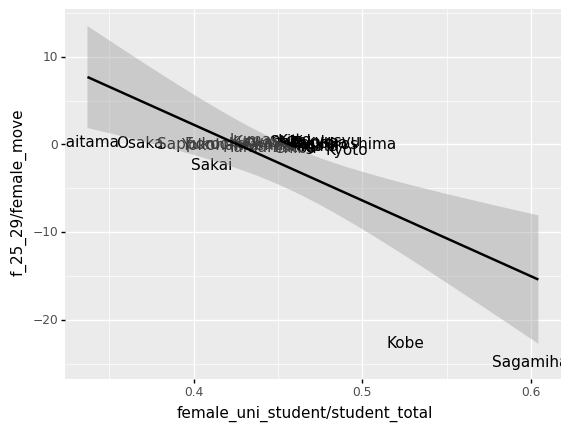

<ggplot: (301268718)>

In [30]:
(
    ggplot(city_pct, aes(y='f_25_29/female_move', x= 'female_uni_student/student_total'))
    + geom_text(aes(label='city'))
    + stat_smooth(method='lm')
)

In [ ]:
population

In these several charts, we find that Kobe is an outlier, meaning there are way more female in the age group of 15-24 moving in to Kebe compared to other cities; but it's losing female population of 25-29.

/Users/angeline_jcq/.pyenv/versions/3.9.7/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 5 rows containing missing values.


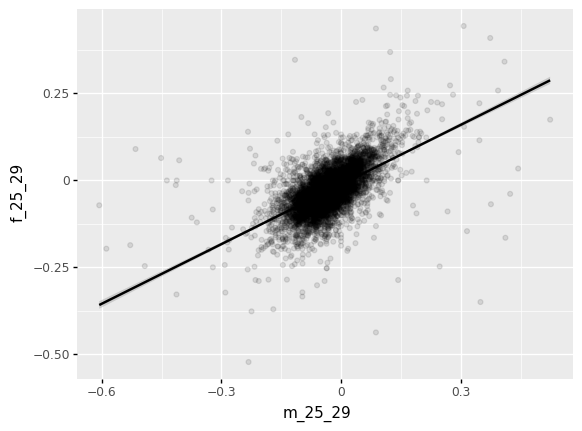

<ggplot: (302648405)>

In [126]:
(
    ggplot(df_pct, aes(y='f_25_29', x= 'm_25_29'))
    + geom_point(alpha=.1)
    + stat_smooth(method='lm')
)

In [124]:
df_pct.head()

,year_x,place,total_15_19,total_20_24,total_25_29,m_15_19,m_20_24,m_25_29,f_15_19,f_20_24,f_25_29,city_county,year_y,total_pop,male_pop,female_pop,total_youth,total_male_youth,total_female_youth
0,2016,札幌市,0.075251,0.083258,0.010388,0.029796,0.023462,0.003801,0.045455,0.059795,0.006588,city,2020.0,1973395.0,918682.0,1054713.0,0.168897,0.057059,0.111838
1,2016,函館市,-0.129439,-0.128244,-0.067308,-0.084832,-0.060936,-0.023498,-0.044607,-0.067308,-0.043810,city,2020.0,251084.0,113965.0,137119.0,-0.324991,-0.169266,-0.155725
2,2016,小樽市,-0.014376,-0.299194,-0.172508,-0.018868,-0.169813,-0.052112,0.004492,-0.129381,-0.120396,city,2020.0,111299.0,50136.0,61163.0,-0.486078,-0.240793,-0.245285
3,2016,旭川市,-0.073488,-0.085938,-0.086849,-0.047069,-0.030063,-0.029456,-0.026419,-0.055875,-0.057393,city,2020.0,329306.0,152108.0,177198.0,-0.246276,-0.106588,-0.139688
4,2016,室蘭市,0.116529,-0.252479,-0.193001,0.131095,-0.167510,-0.115315,-0.014566,-0.084969,-0.077686,city,2020.0,82383.0,40390.0,41993.0,-0.328951,-0.151730,-0.177221


# Regression

In [39]:
df_pct = df_pct.assign(
    pct_female = lambda x: x.female_pop / x.total_pop,
    pct_male = lambda x: x.male_pop / x.total_pop
)
df_pct

,year_x,place,total_15_19,total_20_24,total_25_29,m_15_19,m_20_24,m_25_29,f_15_19,f_20_24,f_25_29,city_county,year_y,total_pop,male_pop,female_pop,total_youth,total_male_youth,total_female_youth,pct_female,pct_male
0,2016,札幌市,0.075251,0.083258,0.010388,0.029796,0.023462,0.003801,0.045455,0.059795,0.006588,city,2020.0,1973395.0,918682.0,1054713.0,0.168897,0.057059,0.111838,0.534466,0.465534
1,2016,函館市,-0.129439,-0.128244,-0.067308,-0.084832,-0.060936,-0.023498,-0.044607,-0.067308,-0.043810,city,2020.0,251084.0,113965.0,137119.0,-0.324991,-0.169266,-0.155725,0.546108,0.453892
2,2016,小樽市,-0.014376,-0.299194,-0.172508,-0.018868,-0.169813,-0.052112,0.004492,-0.129381,-0.120396,city,2020.0,111299.0,50136.0,61163.0,-0.486078,-0.240793,-0.245285,0.549538,0.450462
3,2016,旭川市,-0.073488,-0.085938,-0.086849,-0.047069,-0.030063,-0.029456,-0.026419,-0.055875,-0.057393,city,2020.0,329306.0,152108.0,177198.0,-0.246276,-0.106588,-0.139688,0.538095,0.461905
4,2016,室蘭市,0.116529,-0.252479,-0.193001,0.131095,-0.167510,-0.115315,-0.014566,-0.084969,-0.077686,city,2020.0,82383.0,40390.0,41993.0,-0.328951,-0.151730,-0.177221,0.509729,0.490271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6665,2021,国頭郡,-0.163837,-0.065856,-0.062644,-0.070675,-0.025700,-0.016062,-0.093162,-0.040156,-0.046581,county,2020.0,62257.0,31493.0,30764.0,-0.292337,-0.112437,-0.179899,0.494145,0.505855
6666,2021,中頭郡,0.000000,-0.185398,0.024678,0.009491,-0.120857,0.006328,-0.009491,-0.064541,0.018350,county,2020.0,158038.0,77636.0,80402.0,-0.160721,-0.105038,-0.055683,0.508751,0.491249
6667,2021,島尻郡,-0.137793,-0.005702,0.032310,-0.080775,0.015205,0.006652,-0.057018,-0.020907,0.025658,county,2020.0,105230.0,52345.0,52885.0,-0.111185,-0.058919,-0.052266,0.502566,0.497434
6668,2021,宮古郡,-0.567108,-0.378072,0.094518,-0.283554,0.000000,0.094518,-0.283554,-0.378072,0.000000,county,2020.0,1058.0,575.0,483.0,-0.850662,-0.189036,-0.661626,0.456522,0.543478


In [41]:
model = smf.ols("pct_female ~ total_female_youth", data= df_pct)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             pct_female   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     366.4
Date:                Tue, 10 May 2022   Prob (F-statistic):           1.48e-79
Time:                        13:36:32   Log-Likelihood:                 18724.
No. Observations:                6665   AIC:                        -3.744e+04
Df Residuals:                    6663   BIC:                        -3.743e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.5114      0.000   2047.024      0.000       0.511       0.512
total_female_youth    -0.0204      0.001    -19.143      0.000      -0.023      -0.018
==============================================================================
Omnibus:                     3879.617   Durbin-Watson:                   1.234
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           110786.850
Skew:                          -2.266   Prob(JB):                         0.00
Kurtosis:                      22.452   Cond. No.                         6.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
model = smf.ols("m_20_24 ~ m_25_29", data= df_pct)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                m_20_24   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     682.5
Date:                Tue, 10 May 2022   Prob (F-statistic):          2.53e-143
Time:                        13:37:28   Log-Likelihood:                 5916.2
No. Observations:                6665   AIC:                        -1.183e+04
Df Residuals:                    6663   BIC:                        -1.181e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0620      0.001    -46.700      0.000      -0.065      -0.059
m_25_29        0.4785      0.018     26.125      0.000       0.443       0.514
==============================================================================
Omnibus:                     3543.502   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           436983.055
Skew:                          -1.560   Prob(JB):                         0.00
Kurtosis:                      42.545   Cond. No.                         15.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
model = smf.ols("f_20_24 ~ f_25_29 + f_15_19", data= df_pct)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                f_20_24   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     816.3
Date:                Tue, 10 May 2022   Prob (F-statistic):          8.58e-318
Time:                        13:38:30   Log-Likelihood:                 6462.0
No. Observations:                6665   AIC:                        -1.292e+04
Df Residuals:                    6662   BIC:                        -1.290e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0688      0.001    -50.403      0.000      -0.071      -0.066
f_25_29        0.5828      0.018     33.144      0.000       0.548       0.617
f_15_19        0.3595      0.017     21.610      0.000       0.327       0.392
==============================================================================
Omnibus:                     1971.968   Durbin-Watson:                   1.627
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           105349.212
Skew:                           0.612   Prob(JB):                         0.00
Kurtosis:                      22.438   Cond. No.                         15.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
model = smf.ols("f_25_29 ~ f_20_24 + f_15_19 + m_20_24 + m_15_19 + m_25_29", data= df_pct)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                f_25_29   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     864.9
Date:                Tue, 10 May 2022   Prob (F-statistic):               0.00
Time:                        13:42:44   Log-Likelihood:                 10531.
No. Observations:                6665   AIC:                        -2.105e+04
Df Residuals:                    6659   BIC:                        -2.101e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0015      0.001     -1.762      0.078      -0.003       0.000
f_20_24        0.0360      0.009      4.041      0.000       0.019       0.053
f_15_19       -0.0456      0.013     -3.618      0.000      -0.070      -0.021
m_20_24        0.0947      0.008     11.573      0.000       0.079       0.111
m_15_19        0.0758      0.009      8.103      0.000       0.057       0.094
m_25_29        0.5071      0.010     50.579      0.000       0.487       0.527
==============================================================================
Omnibus:                     1420.775   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30749.268
Skew:                          -0.468   Prob(JB):                         0.00
Kurtosis:                      13.481   Cond. No.                         24.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [112]:
df_pct

,year_x,place,total_15_19,total_20_24,total_25_29,m_15_19,m_20_24,m_25_29,f_15_19,f_20_24,f_25_29,city_county,year_y,total_pop,male_pop,female_pop,total_youth,total_male_youth,total_female_youth
0,2016,札幌市,0.075251,0.083258,0.010388,0.029796,0.023462,0.003801,0.045455,0.059795,0.006588,city,2020.0,1973395.0,918682.0,1054713.0,0.168897,0.057059,0.111838
1,2016,函館市,-0.129439,-0.128244,-0.067308,-0.084832,-0.060936,-0.023498,-0.044607,-0.067308,-0.043810,city,2020.0,251084.0,113965.0,137119.0,-0.324991,-0.169266,-0.155725
2,2016,小樽市,-0.014376,-0.299194,-0.172508,-0.018868,-0.169813,-0.052112,0.004492,-0.129381,-0.120396,city,2020.0,111299.0,50136.0,61163.0,-0.486078,-0.240793,-0.245285
3,2016,旭川市,-0.073488,-0.085938,-0.086849,-0.047069,-0.030063,-0.029456,-0.026419,-0.055875,-0.057393,city,2020.0,329306.0,152108.0,177198.0,-0.246276,-0.106588,-0.139688
4,2016,室蘭市,0.116529,-0.252479,-0.193001,0.131095,-0.167510,-0.115315,-0.014566,-0.084969,-0.077686,city,2020.0,82383.0,40390.0,41993.0,-0.328951,-0.151730,-0.177221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6665,2021,国頭郡,-0.163837,-0.065856,-0.062644,-0.070675,-0.025700,-0.016062,-0.093162,-0.040156,-0.046581,county,2020.0,62257.0,31493.0,30764.0,-0.292337,-0.112437,-0.179899
6666,2021,中頭郡,0.000000,-0.185398,0.024678,0.009491,-0.120857,0.006328,-0.009491,-0.064541,0.018350,county,2020.0,158038.0,77636.0,80402.0,-0.160721,-0.105038,-0.055683
6667,2021,島尻郡,-0.137793,-0.005702,0.032310,-0.080775,0.015205,0.006652,-0.057018,-0.020907,0.025658,county,2020.0,105230.0,52345.0,52885.0,-0.111185,-0.058919,-0.052266
6668,2021,宮古郡,-0.567108,-0.378072,0.094518,-0.283554,0.000000,0.094518,-0.283554,-0.378072,0.000000,county,2020.0,1058.0,575.0,483.0,-0.850662,-0.189036,-0.661626


In [80]:
model = smf.ols("f_25_29 ~ f_20_24 + f_15_19 + m_20_24 + m_15_19 + m_25_29", data= df_pct.query("city_county=='city'"))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                f_25_29   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     1051.
Date:                Tue, 10 May 2022   Prob (F-statistic):               0.00
Time:                        14:02:26   Log-Likelihood:                 8690.2
No. Observations:                4727   AIC:                        -1.737e+04
Df Residuals:                    4721   BIC:                        -1.733e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0005      0.001     -0.611      0.542      -0.002       0.001
f_20_24        0.0248      0.010      2.566      0.010       0.006       0.044
f_15_19       -0.1061      0.014     -7.820      0.000      -0.133      -0.079
m_20_24        0.0877      0.009      9.684      0.000       0.070       0.105
m_15_19        0.1200      0.011     11.178      0.000       0.099       0.141
m_25_29        0.6273      0.011     59.285      0.000       0.607       0.648
==============================================================================
Omnibus:                      276.177   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1130.724
Skew:                           0.097   Prob(JB):                    2.93e-246
Kurtosis:                       5.388   Cond. No.                         29.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
model = smf.ols("f_25_29 ~ f_20_24 + m_20_24 + m_15_19 + m_25_29", data= df_pct.query("city_county=='county'"))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                f_25_29   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     168.2
Date:                Tue, 10 May 2022   Prob (F-statistic):          1.13e-123
Time:                        13:44:16   Log-Likelihood:                 2447.5
No. Observations:                1938   AIC:                            -4885.
Df Residuals:                    1933   BIC:                            -4857.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0010      0.003     -0.371      0.710      -0.006       0.004
f_20_24        0.0598      0.019      3.230      0.001       0.023       0.096
m_20_24        0.1091      0.016      6.744      0.000       0.077       0.141
m_15_19        0.0493      0.014      3.401      0.001       0.021       0.078
m_25_29        0.3706      0.020     18.170      0.000       0.331       0.411
==============================================================================
Omnibus:                      345.326   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3995.133
Skew:                          -0.473   Prob(JB):                         0.00
Kurtosis:                       9.970   Cond. No.                         15.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

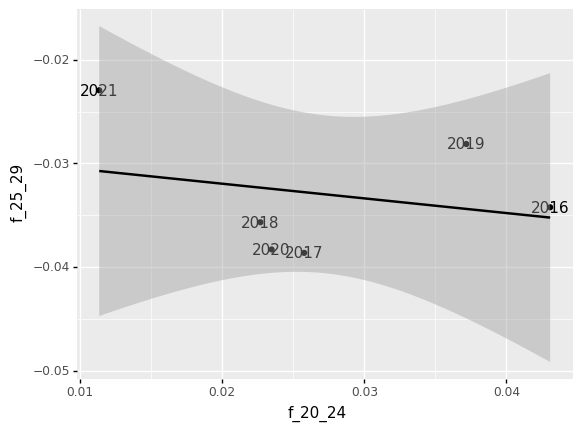

<ggplot: (301445572)>

In [65]:
(
    ggplot(df_pct.query("place=='神戸市'"), aes(y='f_25_29', x= 'f_20_24'))
    + geom_point()
    + geom_text(aes(label='year_x'))
    + stat_smooth(method='lm')
)

/Users/angeline_jcq/.pyenv/versions/3.9.7/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 5 rows containing missing values.


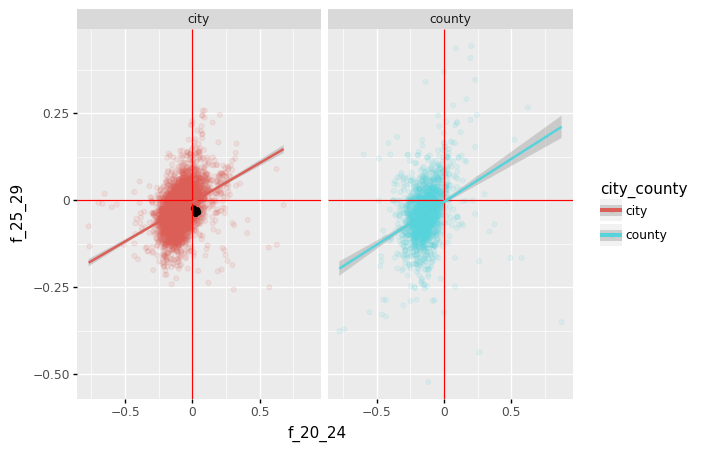

<ggplot: (299025652)>

In [114]:
(
    ggplot(df_pct, aes(y='f_25_29', x= 'f_20_24',color='city_county'))
    + geom_point(alpha=.1)
    + geom_point(df_pct.query("place=='神戸市'"), aes(y='f_25_29', x= 'f_20_24'), color= 'black')
    + geom_hline(aes(yintercept=0), color='red')
    + geom_vline(aes(xintercept=0), color='red')
    + facet_wrap('city_county')
    + stat_smooth(method='lm')
)

/Users/angeline_jcq/.pyenv/versions/3.9.7/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 5 rows containing missing values.


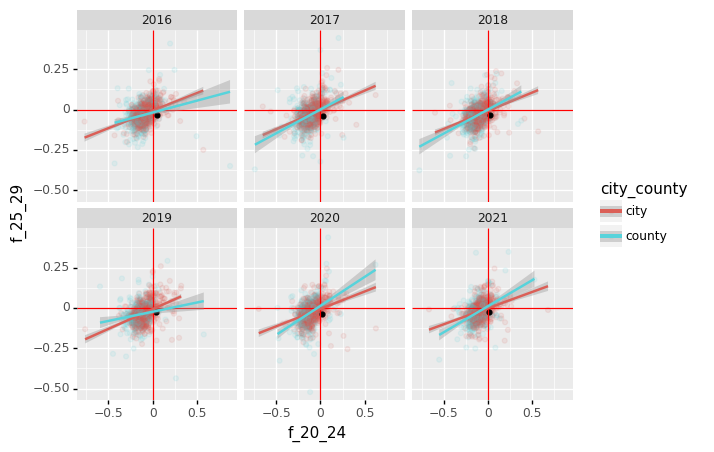

<ggplot: (299879015)>

In [79]:
(
    ggplot(df_pct, aes(y='f_25_29', x= 'f_20_24',color='city_county'))
    + geom_point(alpha=.1)
    + geom_point(df_pct.query("place=='神戸市'"), aes(y='f_25_29', x= 'f_20_24'), color= 'black')
    + geom_hline(aes(yintercept=0), color='red')
    + geom_vline(aes(xintercept=0), color='red')
    + facet_wrap("year_x")
    + stat_smooth(method='lm')
)